## Import Images

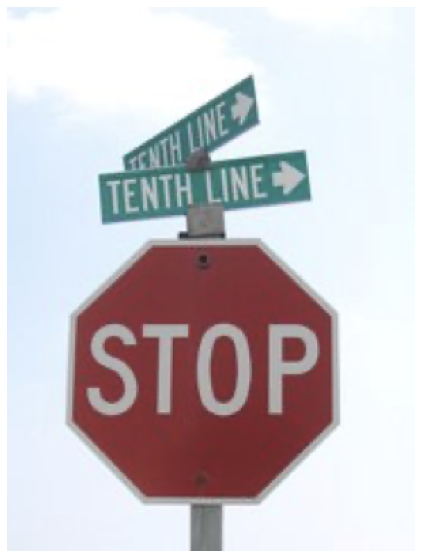

In [292]:
#!/bin/python3

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# First 51 imgs are semaphores
def importImage(no):
    return cv.imread('dataset/images/road' + str(no) + '.png', cv.IMREAD_COLOR)

def displayImage(image, title=""):
    if (len(image.shape) == 3):
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        cmap = None
    else:
        cmap = "gray"
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

displayImage(importImage(52))

## Export XML

In [293]:
import xml.etree.ElementTree as ET

df = pd.DataFrame(columns=["type"])

for i in range(0, 877):
    with open(f"dataset/annotations/road{i}.xml") as xml:
        tree = ET.parse(xml)
        root = tree.getroot()
        
        objects = root.findall("object")
        types = []
        for object in objects:
            types.append(object.find("name").text)

        df.loc[i] = ([types])

df.to_csv("dataset/signs.csv", index=False)

## Import XML

In [294]:
signs = pd.read_csv("dataset/signs.csv")

def typeToList(x):
    x["type"] = x["type"].replace("[", "")
    x["type"] = x["type"].replace("]", "")
    x["type"] = x["type"].replace("'", "")
    x["type"] = x["type"].strip()
    x["type"] = x["type"].split(", ")
    return x["type"]

signs["type"] = signs.apply(typeToList, axis=1)

def filterType(type):
    def filter(x):
        return len(set(x["type"]) & set(type)) != 0

    #print(signs.apply(filter, axis=1))
    return signs[signs.apply(filter, axis=1) == True]

filterType(["speedlimit"])

,type
100,[speedlimit]
101,[speedlimit]
102,[speedlimit]
103,[speedlimit]
104,[speedlimit]
...,...
871,[speedlimit]
872,"[speedlimit, stop]"
873,"[speedlimit, speedlimit, stop]"
874,"[speedlimit, speedlimit, stop]"


## Segmentação em áreas de interesse
Nesta secção iremos delimitar quais as áreas em que estamos interessados em analisar. Estas regiões correspondem às que contêm os sinais. Para isso iremos usar o colorspace HSV para filtrar as cores de interesse: **azul** e **vermelho**


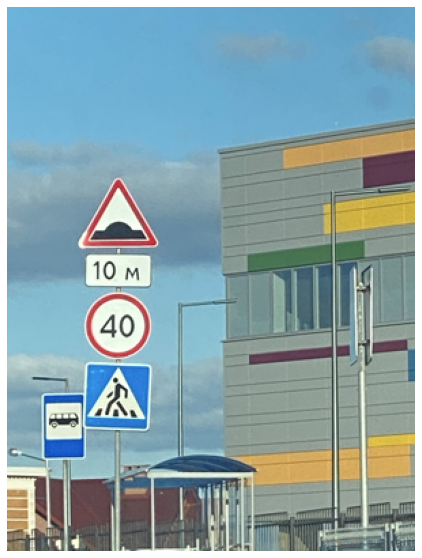

In [477]:
testImages = {"speedlimit": (7, 19, 20, 70)}
speedLimitId = filterType(["crosswalk"]).index[10]
speedLimitId = 576
speedLimit = importImage(speedLimitId)
#speedLimit = cv.imread('dataset/images/test.png')
displayImage(speedLimit)

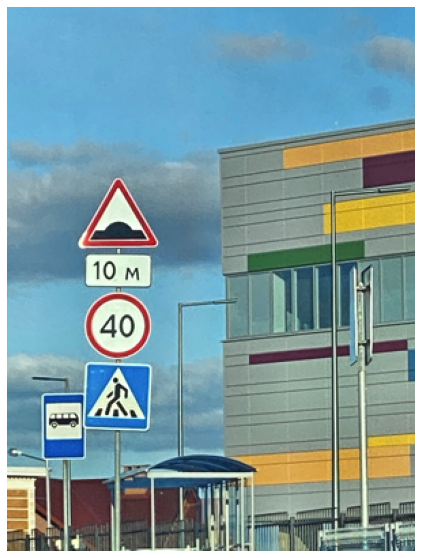

In [478]:
clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
hsv = cv.cvtColor(speedLimit, cv.COLOR_BGR2HSV)
h,s,v = cv.split(hsv)
s = clahe.apply(s)
v = clahe.apply(v)
img = cv.merge([h, s, v])
speedLimit = cv.cvtColor(img, cv.COLOR_HSV2BGR)
displayImage(speedLimit)

### Mean Shift
Usado para uniformizar cor da imagem

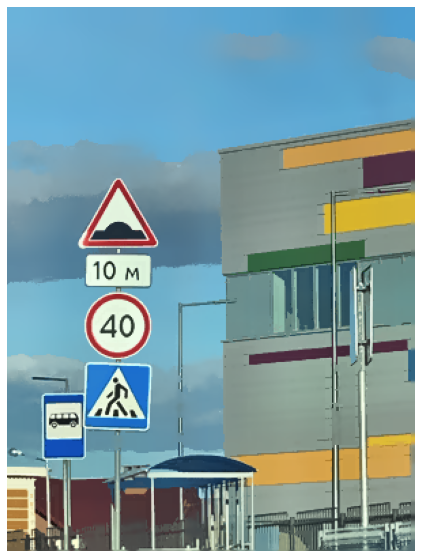

In [479]:
img = speedLimit

segmentedRoadImg = cv.pyrMeanShiftFiltering(img, 10, 25, 100)

displayImage(segmentedRoadImg)

### Filtro usando HSV
Utilizando as equações em TODO, podemos usar um threshold para selecionar apenas a regiões de forte saturação com fortes intensidades de vermelho ou azul.

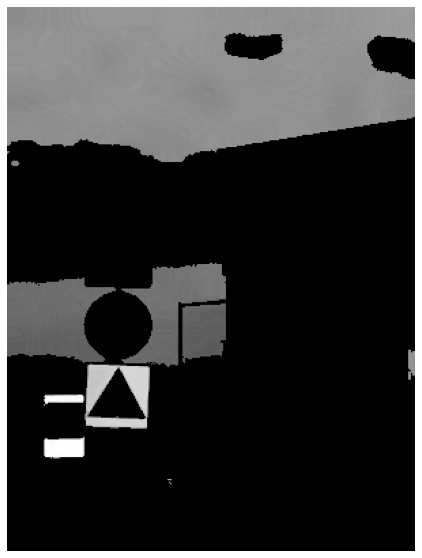

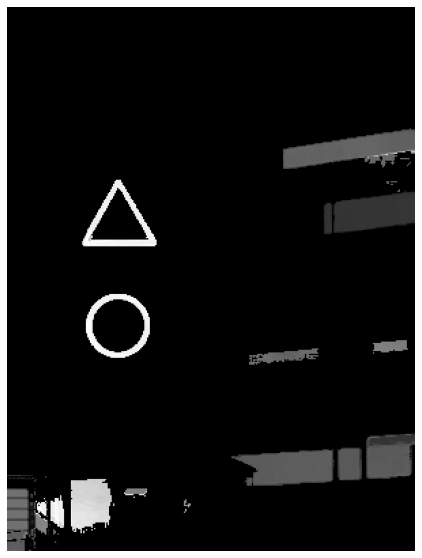

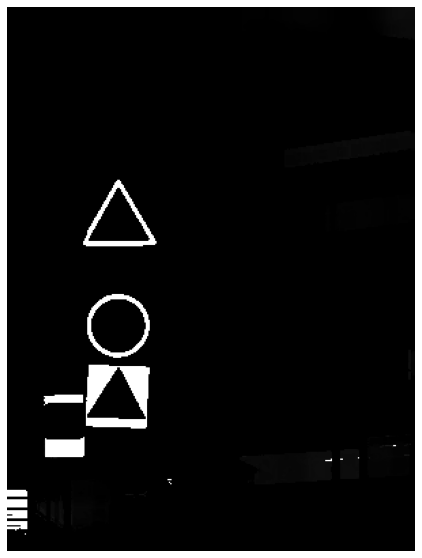

(None, None, None)

In [480]:
def splitColor(img):
    def calcScore(B, G, R, S):
        R /= 255
        G /= 255
        B /= 255
        TH1, TH2 = 0.40/3, 0.7 / 3
        DIFF_TH_B = 80 / 255
        DIFF_TH_R = 32 / 255
        c_max = max(R, G, B)
        c_min = min(R, G, B)

        if (c_max == B and (c_max - c_min) >= DIFF_TH_B):
            hd_blue = 1 - abs(R - G) / (c_max - c_min)
        else:
            hd_blue = 0

        if (c_max == R and (c_max - c_min) >= DIFF_TH_R):
            hd_red = 1 - abs(G - B) / (c_max - c_min)
        else:
            hd_red = 0
        from math import e
        sd = e ** -(((S - 255) ** 2) / (115 ** 2))

        hs = max(hd_blue, hd_red) * min(sd * 1, 1)
        if hs < TH1:
            hs = 0
        elif TH1 <= hs < TH2:
            hs = ((hs - TH1) ** 2) / (TH2 - TH1)
        else:
            hs = 1

        return hd_blue * 255, hd_red * 255, hs * 255


    height, width = img.shape[0], img.shape[1]
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    b, g, r = cv.split(img)
    h, s, v = cv.split(hsv)
    blank_image_b = np.zeros((height, width), np.uint8)
    blank_image_r = np.zeros((height, width), np.uint8)
    blank_image_hs = np.zeros((height, width), np.uint8)

    for i in range(height):
        for j in range(width):
            b_val, r_val, hs_val = calcScore(b[i, j], g[i, j], r[i, j], s[i, j])
            blank_image_b[i, j] = b_val
            blank_image_r[i, j] = r_val
            blank_image_hs[i, j] = hs_val

    return (blank_image_b, blank_image_r, blank_image_hs)
65
b, r, hs = splitColor(segmentedRoadImg)
displayImage(b), displayImage(r), displayImage(hs)

### Bounding Boxes - Detecting ROI
Falar um pouco disto
Ainda falta meter um min size nos countours TODO

#### Draw Edges

Apply gaussian blur, then Canny first and then morph close to close neighbouring edges

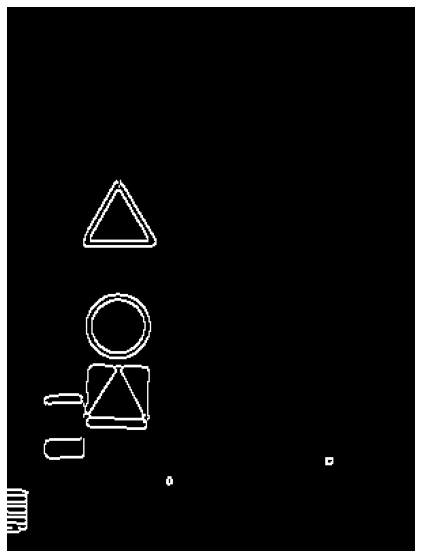

In [481]:
def getEdges(img):
    #img = cv.blur(img, (5, 5))
    img = cv.GaussianBlur(img, (5, 5), 2)
    img = cv.Canny(img, 10, 200)
    img = cv.morphologyEx(img, cv.MORPH_DILATE, (3, 3), iterations=1)
    return img
hs_edges = getEdges(hs.copy())
displayImage(hs_edges)

Draw contours and filter them out. Draw a bounding rectangle for each one.

#### Draw Contours and find bounding rectangles

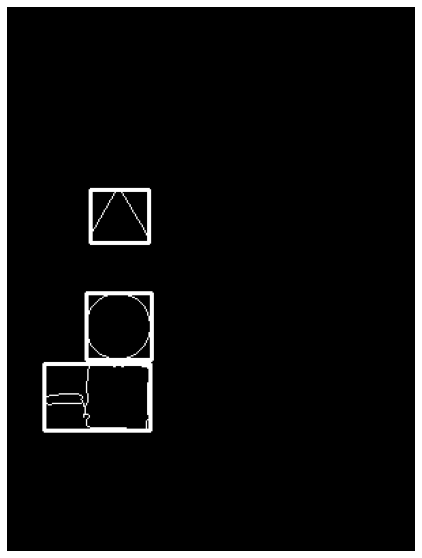

In [482]:
def getCountours(img):
    # Returns list of filtered countours => tuple(countour and its bounding rectangle)
    MIN_SIZE = 10
    MIN_COUNT_RECT_RATIO = 0.5
    MIN_ASPECT_RATIO = 0.6

    ret, thresh = cv.threshold(img,5,10,0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) # TODO

    countours_rects = []
    for i in range(len(contours)):
        cnt = contours[i]
        x,y,w,h = cv.boundingRect(cnt)
        rect = (x, y, w, h)
        # Rect has a minimum size
        if (w < MIN_SIZE or h < MIN_SIZE):
            continue
        # Contour needs to be closed
        contourArea = cv.contourArea(cnt)
        if contourArea <= cv.arcLength(cnt, True):
            continue
        # Percentage contour area needs to be higher than threshold
        contourAreaPerc = contourArea / (w * h)
        if contourAreaPerc <= MIN_COUNT_RECT_RATIO:
            continue
        aspect_ratio = min(w, h) / max(w, h)
        # Aspect ratio needs to be higher than threshold
        if aspect_ratio <= MIN_ASPECT_RATIO:
            continue
        
        countours_rects.append((cnt, rect))
    return countours_rects

#drawing = hs_edges.copy()
drawing = np.zeros((hs_edges.shape[0], hs_edges.shape[1], 1), np.uint8)
countours = getCountours(hs_edges.copy())
for cnt, (x, y, w, h) in countours:
    cv.drawContours(drawing, [cnt], 0, 500)
    cv.rectangle(drawing, (x,y), (x + w, y + h), 255, 2)

displayImage(drawing)

Filter out rectangles that are contained inside orders

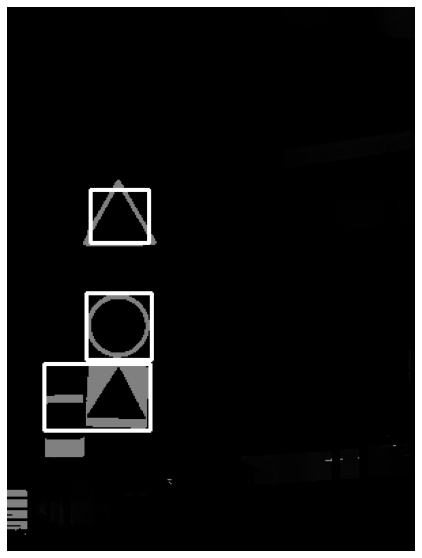

In [483]:
def filterCountours(candidate_countours):
    def isInsideRects(rect, rects):
        def isInside(r1, r2):
            (r1_x1, r1_y1, r1_w, r1_h) = r1
            r1_x2, r1_y2 = r1_x1 + r1_w, r1_y1 + r1_h
            (r2_x1, r2_y1, r2_w, r2_h) = r2
            r2_x2, r2_y2 = r2_x1 + r2_w, r2_y1 + r2_h
            return r1_x1 < r2_x1 < r2_x2 < r1_x2 and r1_y1 < r2_y1 < r2_y2 < r1_y2
        for r in rects:
            if isInside(r, rect):
                return True
        return False

    # Process bigger area rectanles first
    candidate_countours.sort(key=lambda x: x[1][2] * x[1][3], reverse=True)
    countours, rects = [], []
    for cnt, rect in candidate_countours:
        if not isInsideRects(rect, rects):
            countours.append((cnt, rect))
            rects.append(rect)

    return countours

countours = filterCountours(countours)
drawing = hs.copy()
drawing = drawing / 2
i = 0
for cnt, (x, y, w, h) in countours:
    i += 1
    cv.rectangle(drawing, (x, y), (x + w, y + h), 255, 2)

displayImage(drawing)

## Harris Corner Detection

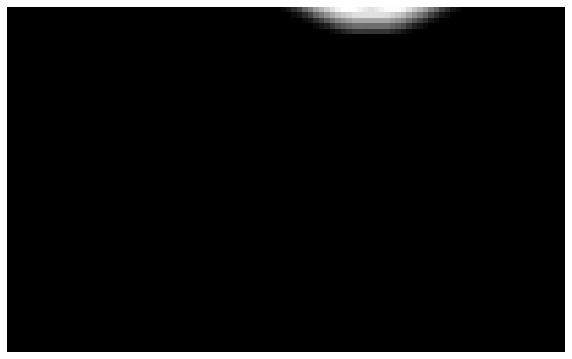

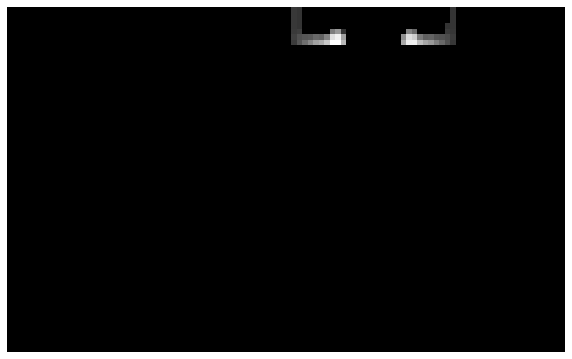

In [484]:
def addPadding(rect, img, padding):
    # Adds padding to a rect bounding box so that corner detection can be more accurate
    w, h = rect[2], rect[3]
    y1 = max(0, round(rect[1] - h * padding))
    y2 = min(img.shape[0], round(rect[1] + h + h * padding))
    x1 = max(0, round(rect[0] - w * padding))
    x2 = min(img.shape[1], round(rect[0] + w + w * padding))

    return img[y1:y2, x1:x2]

def getCorners(roi):
    neighbourhood = max(roi.shape[0], roi.shape[1]) // 8
    aperture = 3
    free_param = 0.04
    harris = cv.cornerHarris(roi, neighbourhood, aperture, free_param)
    threshold = 0.20

    harris[harris < threshold * harris.max()] = 0
    return harris

rect = countours[0][1]
blur = cv.blur(r.copy(),(5,5))
roi = addPadding(rect, blur, 0.15)
corners = getCorners(roi)
displayImage(roi)
displayImage(corners)

### Corner Detection - Triangle and square identification

In [485]:
def cornerIdentification(corners):
    corners = corners.copy()
    w, h= corners.shape[0], corners.shape[1]
    # Identify areas of interest inside the roi
    ratio = 1 / 8
    x_tick = round(w * ratio)
    y_tick = round(h * ratio)
    tl_range = slice(0, 2 * y_tick + 1), slice(0, 2 * x_tick + 1)
    tr_range = slice(0, 2 * y_tick + 1), slice(6 * x_tick, w + 1)
    bl_range = slice(6 * y_tick, h + 1), slice(0, 2 * x_tick + 1)
    br_range = slice(6 * y_tick, h + 1), slice(6 * x_tick, w + 1)

    tc_range = slice(0, 2 * y_tick + 1), slice(3 * x_tick, 5 * x_tick + 1)
    bc_range = slice(6 * y_tick, h + 1), slice(3 * x_tick, 5 * x_tick + 1)

    # Assign values if corners are found inside them
    tl, tr, bl, br = 0, 0, 0, 0
    if np.any(corners[tl_range]): tl = 0.25
    if np.any(corners[tr_range]): tr = 0.25
    if np.any(corners[bl_range]): bl = 0.25
    if np.any(corners[br_range]): br = 0.25

    tc, bc = 0, 0
    if np.any(corners[tc_range]): tc = 0.34
    if np.any(corners[bc_range]): bc = 0.34

    square = tl + tr + bl + br
    triangle_up = 1.32 * (bl + br) + tc - 1.1 * (tl + tr)
    triangle_down = 1.32 * (tl + tr) + bc - 1.1 * (bl + br)

    # print(square, triangle_up, triangle_down)
    return square, triangle_up, triangle_down

    
cornerIdentification(corners)

(0.25, -0.275, 0.33)

### Circle Detection

In [486]:
MIN_RADIUS = 30
def circleIdentificationBad(roi):
    import frs
    r_w, r_h = roi.shape[0], roi.shape[1]

    frs_res = frs.frst(roi, max(r_w, r_h) // 2, 2, 0, max(r_w, r_h) / 4, "BRIGHT")
    w, h = frs_res.shape[0], frs_res.shape[1]
    dim = max(w, h)
    tick = 1 / 5
    region = slice(round(2 * tick * dim), round(3 * tick * dim)), slice(round(2 * tick * dim), round(3 * tick * dim))

    m = frs_res[region].max()
    avg = np.average(frs_res[region])
    # print("M: ", m, "AVG: ", avg, avg / m)
    # print(frs_res[region])
    #displayImage(frs_res[region])
    #displayImage(frs_res)
    cp = avg / m
    return cp


rect = countours[0][1]
blur = cv.blur(r.copy(),(5,5))
roi = addPadding(rect, blur, 0.15)
# circleIdentification(roi)

def circleIdentification(roi): # Octogono => 92% area of circle
    ret, thresh = cv.threshold(roi,100,200,0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) # TODO
    if (len(contours) == 0):
        return 0

    for cnt in contours:
        cv.drawContours(roi, [cnt], 0, 500)
    #displayImage(roi)

    cnt = contours[0]
    (x, y), r = cv.minEnclosingCircle(cnt)
    area_circle = np.pi * r ** 2
    contourArea = cv.contourArea(cnt)

    return contourArea / area_circle

circleIdentification(roi)


0.08417959430106471

## Shape detection

Blue - Square:  0.25  TriUp:  0.065  TriDown:  0.33  Circle:  0.10586387465907521
Red - Square:  0.25  TriUp:  -0.275  TriDown:  0.33  Circle:  0.14366935617250268
Blue - Square:  0.25  TriUp:  0.33  TriDown:  -0.275  Circle:  0.0
Red - Square:  0  TriUp:  0.0  TriDown:  0.0  Circle:  0.9476124529547755


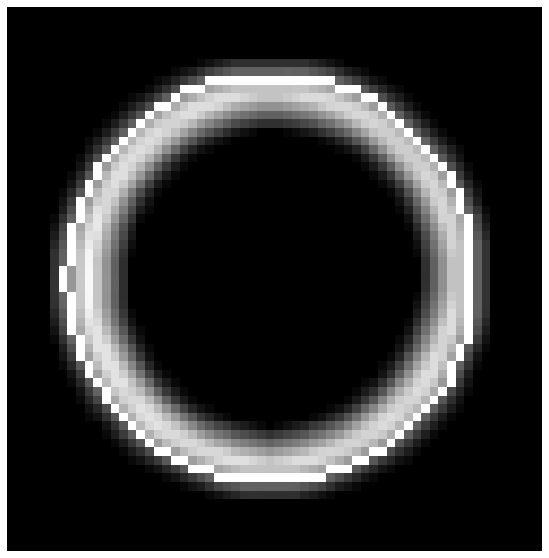

Blue - Square:  0  TriUp:  0.0  TriDown:  0.0  Circle:  0
Red - Square:  0.5  TriUp:  1.0  TriDown:  -0.55  Circle:  0.4838048150940696


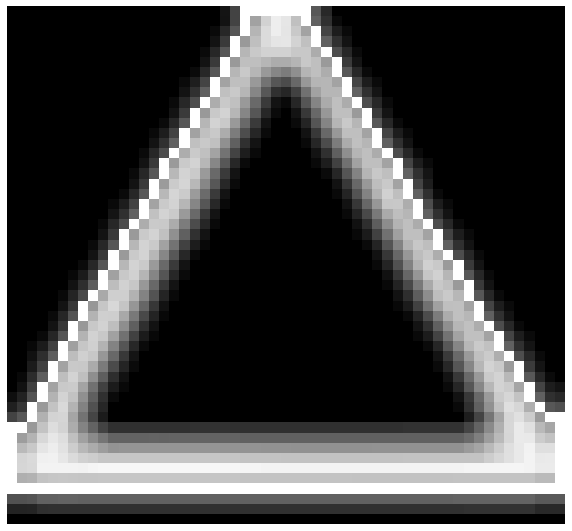

['trash', 'prohibition', 'danger']

In [487]:
COLOR_THRESHOLD = 0.5
SHAPE_THRESHOLD = 0.4
CIRCLE_THRESHOLD = 0.9

# from enum import Enum
# class Sign(Enum):
#     STOP = 1
#     INFORMATION = 2
#     SPEEDLIMIT = 3
#     WARNING = 4
#     PRIORITY = 5

def get_signs(b, r, countours):

    def sign(b, r, rect):
        kernel_blur = 5
        blue = addPadding(rect, b, 0.15)
        blue = cv.blur(blue.copy(),(kernel_blur, kernel_blur))
        red = addPadding(rect, r, 0.15)
        red = cv.blur(red.copy(),(kernel_blur, kernel_blur))
        # Blue
        corners_b = getCorners(blue)
        sq_b, t_up_b, t_down_b = cornerIdentification(corners_b)
        circle_b = circleIdentification(blue)
        shape_max_b = max(sq_b, t_up_b, t_down_b, circle_b)
        print("Blue - Square: ", sq_b, " TriUp: ", t_up_b, " TriDown: ", t_down_b, " Circle: ", circle_b)
        # Red
        corners_r = getCorners(red)
        sq_r, t_up_r, t_down_r = cornerIdentification(corners_r)
        circle_r = circleIdentification(red)
        shape_max_r = max(sq_r, t_up_r, t_down_r, circle_r)
        print("Red - Square: ", sq_r, " TriUp: ", t_up_r, " TriDown: ", t_down_r, " Circle: ", circle_r)

        if max(shape_max_r, shape_max_b) < SHAPE_THRESHOLD:
            return "trash"

        if shape_max_b > shape_max_r: # Is Blue
            displayImage(blue)
            if sq_b == shape_max_b:
                return "information"
            if circle_b == shape_max_b:
                return "mandatory"
            return "trash"
        else:
            displayImage(red)
            if t_up_r == shape_max_r:
                return "danger"
            if t_down_r == shape_max_r:
                return "yield"
            if circle_r == shape_max_r and circle_r >= CIRCLE_THRESHOLD:
                return "prohibition"
            return "stop"


        return "trash"

    ret = []
    for cnt, rect in countours:
        ret.append(sign(b, r, rect))
    return ret

get_signs(b, r, countours)

